In [1]:
import os 
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

DATA = "../../../data/datasets/merged_files"

%matplotlib inline

In [11]:
list_data = list()
for file in os.listdir(DATA):
    if file.endswith("txt"):
        text = open(os.path.join(DATA, file), "r").read().replace("  ", " ").split("\n")
        for t in text:
            list_data.append([file.split(".")[0], t])
                
data = pd.DataFrame(list_data, columns=["label", "text"])

In [12]:
data = shuffle(data).reset_index()
data.head(10)

,index,label,text
0,4462,clustering,"if a data set really has this structure, clust..."
1,1964,prediction,logistic regression is a type of probabilistic...
2,3608,clustering,one of the most important issues in the cluste...
3,1395,prediction,the basic concept of regression analysis is to...
4,1458,prediction,such classification tasks are used in the dete...
5,3394,clustering,. hierarchical clustering hierarchical cluster...
6,3184,clustering,cluster analysis is an emerging technique to e...
7,2201,prediction,"hence, how the prediction is produced is very ..."
8,135,prediction,stepwise regression analysis is the most commo...
9,5315,frequent_pattern_mining,the possibility of obtaining nonfictitious rep...


In [13]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(data.text).toarray()
labels = data.label
features.shape
# TFIDF Output -> Vector representations in terms of bag of words with tfidf scores per document

(5369, 3391)

## Test multiple models with cross-validation

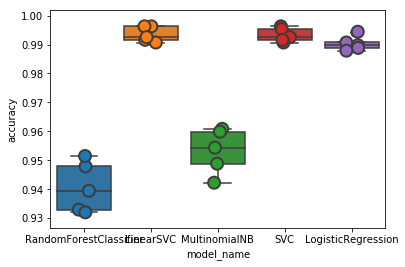

In [18]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    SVC(kernel="linear"),
    LogisticRegression(random_state=0, solver="lbfgs", multi_class="multinomial"),
]


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=12, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [19]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.993480
LogisticRegression        0.990314
MultinomialNB             0.953253
RandomForestClassifier    0.940774
SVC                       0.993294
Name: accuracy, dtype: float64

## Create SVC Classifier

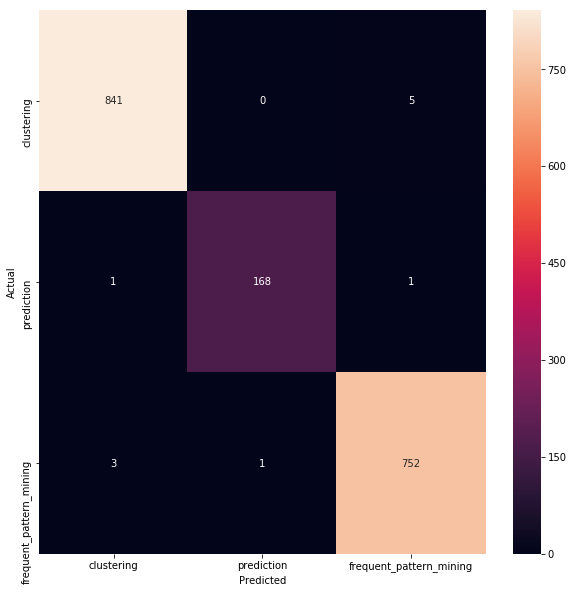

In [20]:
model = LinearSVC()
X_train, X_test, y_train, y_test, _, _ = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=data.label.unique(), yticklabels=data.label.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [22]:
def load_valid_data():
    texts = open("valid.txt", "r").read().split("\n")
    v_labels, v_text = list(), list()
    for text in texts: 
        label, txt = text.split("_")
        v_labels.append(label)
        v_text.append(txt)
    return v_labels, v_text

In [31]:
v_labels, v_texts = load_valid_data()
t, f = 0, 0
for l, txt in zip(v_labels, v_texts):
    pred = model.predict(tfidf.transform([txt]))
    if l == pred[0]:
        t+=1
    else:
        f+=1
    print("Pred: {} | Ground Truth: {}".format(pred[0], l))
print("\nValidation accuracy: {}".format(t/len(v_texts)))

Pred: clustering | Ground Truth: clustering
Pred: prediction | Ground Truth: prediction
Pred: prediction | Ground Truth: prediction
Pred: clustering | Ground Truth: clustering
Pred: prediction | Ground Truth: prediction

Validation accuracy: 1.0
